In [69]:
# Required Libraries
import time
import datetime

import random
import numpy as np
import pandas as pd
import statistics as stats

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
plt.rcParams["figure.autolayout"] = True

from sklearn import model_selection

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, f1_score, precision_score, recall_score


# Random Seed for results reproduction
np.random.seed(7)

# Data Gathering and Preprocessing

In [7]:
# Load the data with tab-separation
raw_data = pd.read_csv("./data/Dmel_matrix__pml.txt", delimiter="\t", header=None)

# Convert to CSV
raw_data.to_csv()

print("Dataset Loaded\n")
print(raw_data.head())

Dataset Loaded

           0   1   2   3   4   5   6   7   8   9   ...     20     21     22  \
0  Refseq_001  31  44   2   3   0   7  10   4   0  ...  0.010 -0.621 -0.616   
1  Refseq_002  13  22   0   2   0  13  21   2  16  ...  0.270  0.012  0.039   
2  Refseq_003  62  94   4  12   4   3   9   0   7  ...  0.779  0.490  0.321   
3  Refseq_004  11   8   2   2   2  53  93  27  35  ...  0.000  0.000  0.000   
4  Refseq_005  41  78   0   3   0   0   0   0   0  ... -0.526 -0.502 -0.597   

      23     24     25     26     27     28  29  
0 -0.808  0.051  0.514 -0.238 -1.558 -1.825   1  
1 -0.171  0.281 -0.079 -0.050  0.163 -0.124   1  
2 -0.089  0.407 -0.222 -0.193 -0.361 -0.521   1  
3  0.000  0.000  0.000  0.000  0.000  0.000   1  
4 -0.336 -0.644 -0.385 -0.395 -0.563 -0.421   1  

[5 rows x 30 columns]


## Check Missing Data

In [9]:
# Check if data has missing values
print(f"Total NaN values: {raw_data.isnull().sum().sum()}")

Total NaN values: 0


## Initial Analysis

In [11]:
# Check Unique Datatypes of the columns
raw_data.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [13]:
# Describe
raw_data.describe()

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
count,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,...,417.000000,417.000000,417.000000,417.00000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
mean,21.597122,22.340528,4.354916,2.393285,1.482014,12.364508,13.431655,3.966427,6.527578,2.021583,...,0.118175,0.119197,0.165029,0.05371,0.067506,0.080122,0.067403,0.025832,0.002837,0.498801
std,20.696195,21.204343,4.346604,2.790567,2.201461,25.463426,26.783153,8.046967,13.540176,4.819034,...,0.565199,0.519949,0.607271,0.27631,0.503606,0.457504,0.351611,0.520642,0.602051,0.500599
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.823000,-1.952000,-2.506000,-0.95600,-2.805000,-1.396000,-1.333000,-1.832000,-2.872000,0.000000
25%,5.000000,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.115000,-0.087000,-0.063000,-0.05100,-0.117000,-0.140000,-0.113000,-0.179000,-0.234000,0.000000
50%,15.000000,16.000000,4.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.017000,0.019000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.000000,32.000000,6.000000,4.000000,2.000000,13.000000,13.000000,4.000000,6.000000,2.000000,...,0.393000,0.435000,0.434000,0.14700,0.346000,0.288000,0.200000,0.242000,0.163000,1.000000
max,128.000000,134.000000,28.000000,21.000000,14.000000,215.000000,224.000000,72.000000,104.000000,42.000000,...,4.583000,2.723000,3.841000,1.23500,2.153000,3.083000,1.352000,3.562000,2.618000,1.000000


## Get Dependent(Target) and Independent(Features) Variables

In [15]:
# Capture the Dependent and Independent Variable
features = raw_data.iloc[:, 1:-1].astype("float64").values  # Independent Varibale with 28 features
target = raw_data.iloc[:, -1].values  # Dependent Variable with 2 classes

print(f"Features Shape: {features.shape}")
print(f"Target Shape: {target.shape}")

Features Shape: (417, 28)
Target Shape: (417,)


# Scale the Data

In [17]:
# Scale the Values using MinMaxScaler
features_scaler = MinMaxScaler()
scaled_features = features_scaler.fit_transform(features)

print(f"Minimum of features is: {scaled_features.min()}")
print(f"Maximum of features is: {scaled_features.max()}")

Minimum of features is: 0.0
Maximum of features is: 1.0000000000000002


# Features Analysis

## Dimensionality Reduction to Visualize the Data

In [19]:
# Create a dataframe to work with

# Create Column Names for features
features_column_names = [f"feature_{i+1}" for i in range(scaled_features.shape[1])]

# Create a dataframe for plotting convenience containing features and targets
plotting_dataframe = pd.DataFrame(scaled_features, columns=features_column_names)
plotting_dataframe["target"] = target

# Cast targets to dtype("str") for plotting convenience
plotting_dataframe["label"] = plotting_dataframe["target"].apply(lambda i: str(i))

plotting_dataframe.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,target,label
0,0.242188,0.328358,0.071429,0.142857,0.000000,0.032558,0.044643,0.055556,0.000000,0.000000,...,0.284706,0.297778,0.067549,0.576039,0.426434,0.407821,0.050797,0.190710,1,1
1,0.101562,0.164179,0.000000,0.095238,0.000000,0.060465,0.093750,0.027778,0.153846,0.047619,...,0.420107,0.400977,0.358284,0.622428,0.294039,0.477840,0.369855,0.500546,1,1
2,0.484375,0.701493,0.142857,0.571429,0.285714,0.013953,0.040179,0.000000,0.067308,0.000000,...,0.522353,0.445407,0.395710,0.647842,0.262112,0.424581,0.272710,0.428233,1,1
3,0.085938,0.059701,0.071429,0.095238,0.142857,0.246512,0.415179,0.375000,0.336538,0.309524,...,0.417540,0.394832,0.436330,0.565752,0.311677,0.496462,0.339637,0.523133,1,1
4,0.320312,0.582090,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.310160,0.300772,0.282976,0.435861,0.225720,0.349348,0.235261,0.446448,1,1


### PCA: Principle Component Analysis

In [21]:
pca_object = PCA(n_components=3)
pca_results = pca_object.fit_transform(plotting_dataframe.iloc[:, :-2])

# Add PCA Results to the plotting dataframe
for i in range(pca_results.shape[1]):
    plotting_dataframe[f"PCA_{i+1}"] = pca_results[:, i]
    
# Get Variations per principal component
variations_per_pca = pca_object.explained_variance_ratio_.tolist() 
print(f"Explained variation per principal component: {variations_per_pca}")
    

Explained variation per principal component: [0.34415506522758776, 0.14905326374273026, 0.11847124253214097]


### t-SNE: T-Distributed Stochastic Neighboring Entities

In [23]:
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(plotting_dataframe.iloc[:, :-2])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# Add t-SNE Results to the plotting dataframe
for i in range(tsne_results.shape[1]):
    plotting_dataframe[f"t-SNE_{i+1}"] = pca_results[:, i]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 417 samples in 0.000s...
[t-SNE] Computed neighbors for 417 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 417 / 417
[t-SNE] Mean sigma: 0.296661
[t-SNE] KL divergence after 250 iterations with early exaggeration: 100.772354
[t-SNE] KL divergence after 300 iterations: 3.103868
t-SNE done! Time elapsed: 0.9440910816192627 seconds


#### Plots

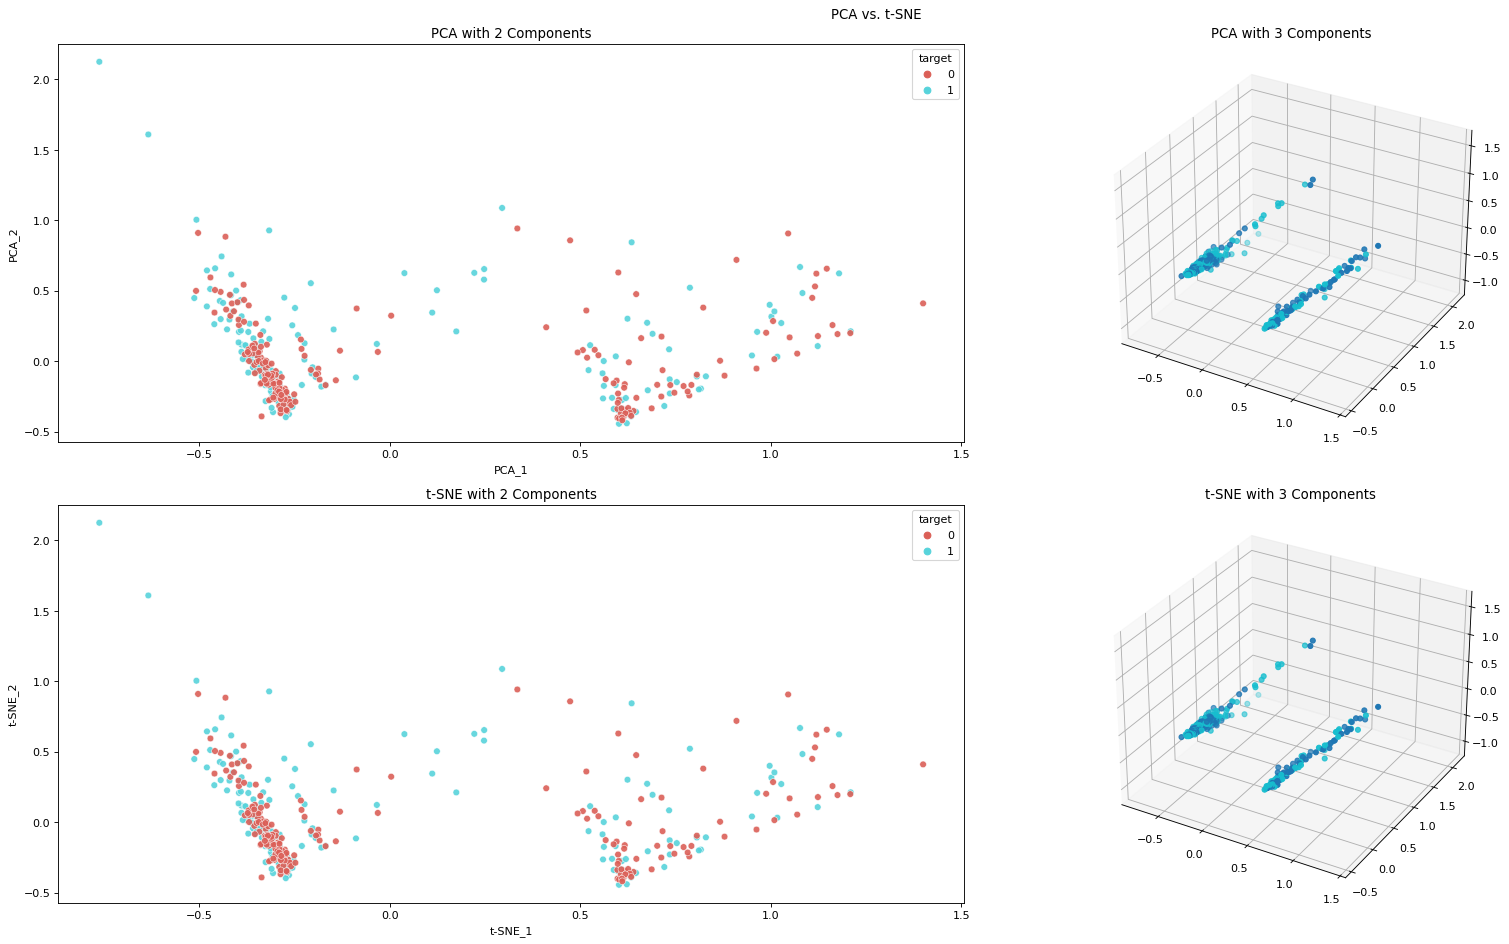

In [118]:
fig = plt.figure(figsize=(22, 12), dpi=80)
fig.suptitle("PCA vs. t-SNE")

# PCA with 2 Components
ax = fig.add_subplot(2, 2, 1)
ax.title.set_text("PCA with 2 Components")
sns.scatterplot(
    x="PCA_1", y="PCA_2",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=plotting_dataframe,
    legend="full",
    alpha=0.9,
    ax=ax
)

# PCA with 3 Components
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.title.set_text("PCA with 3 Components")
ax.scatter(
    xs=plotting_dataframe["PCA_1"], 
    ys=plotting_dataframe["PCA_2"], 
    zs=plotting_dataframe["PCA_3"], 
    c=plotting_dataframe["target"], 
    cmap='tab10',
)

# t-SNE with 2 Components
ax = fig.add_subplot(2, 2, 3)
ax.title.set_text("t-SNE with 2 Components")
sns.scatterplot(
    x="t-SNE_1", y="t-SNE_2",
    hue="target",
    palette=sns.color_palette("hls", 2),
    data=plotting_dataframe,
    legend="full",
    alpha=0.9,
    ax=ax
)

# t-SNE with 3 Components
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.title.set_text("t-SNE with 3 Components")
ax.scatter(
    xs=plotting_dataframe["t-SNE_1"], 
    ys=plotting_dataframe["t-SNE_2"], 
    zs=plotting_dataframe["t-SNE_3"], 
    c=plotting_dataframe["target"], 
    cmap='tab10',
)
plt.show()

In [27]:
# Split the data in train_set and test_set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=seed)

NameError: name 'X' is not defined

In [ ]:
# 1) Logistic Regression
classifier = LogisticRegression(random_state=seed)
print()
print("----------Training Logistic Regression----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score:', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score:', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score:', rs), sep='')
print()
print('Confusion Matrix: {}'.format(cm))
print()

In [ ]:
# 2) k-NN
classifier = KNeighborsClassifier(n_neighbors=5)  # using 5 neighbors
print()
print("----------Training k-NN----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score:', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score:', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score:', rs), sep='')
print()
print('Confusion Matrix: {}'.format(cm))
print()

In [ ]:
# 3) Support Vector Mahcine (SVM)
classifier = SVC(random_state=seed)
print()
print("----------Training SVM----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score:', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score:', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score:', rs), sep='')
print()
print('Confusion Matrix: {}'.format(cm))
print()

In [ ]:
# 4) Decision Trees
classifier = DecisionTreeClassifier(random_state=seed)
print()
print("----------Training Decision Trees----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score:', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score:', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score:', rs), sep='')
print()
print('Confusion Matrix: {}'.format(cm))
print()

In [ ]:
# 5) Random Forest
classifier = RandomForestClassifier(random_state=0)
print()
print("----------Training Random Forest----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score:', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score:', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score:', rs), sep='')
print()
print('Confusion Matrix: {}'.format(cm))
print()

In [ ]:
# 6) Naive Bayes
classifier = GaussianNB()
print()
print("----------Training Naive Bayes----------")
print()
classifier.fit(X_train, y_train)

# Pridiciton of Testset
y_pred = classifier.predict(X_test)

# Confusion Matrix
acc_score = accuracy_score(y_test, y_pred)
apc = average_precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)
rs = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('{:<23}: {:>10.2f}'.format('Accuracy Score', acc_score), sep='')
print('{:<23}: {:>10.2f}'.format('Avarage Precision Score', apc), sep='')
print('{:<23}: {:>10.2f}'.format('f1 Score:', f1), sep='')
print('{:<23}: {:>10.2f}'.format('Precision Score:', ps), sep='')
print('{:<23}: {:>10.2f}'.format('Recall Score:', rs), sep='')
print()
print('Confusion Matrix: {}'.format(cm))
print()

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))

In [ ]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=7, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.savefig('Result.png')

In [ ]:
csv_dict = dict()

for name, result in zip(names, results):
    if name not in csv_dict.keys():
        stats = []
        stats.append(min(result))
        stats.append(statistics.median(result))
        stats.append(max(result))
        stats.append(statistics.variance(result))
        stats.append(statistics.stdev(result))
        
        csv_dict[name] = stats